<a href="https://colab.research.google.com/github/JanHidranovich/machine_learning/blob/main/ae_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape((60000, 28, 28)) / 255
x_test = x_test.reshape((10000, 28, 28)) / 255

y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)
hidden_dim = 8

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = keras.backend.random_normal(shape=(1, hidden_dim), mean=0.0, stddev=1.0)
  return keras.backend.exp(z_log_var / 2) * N + z_mean

In [4]:
input = keras.layers.Input(shape=(28, 28))
fl = keras.layers.Flatten()(input)
label = keras.layers.Input(shape=(10,))
x = keras.layers.concatenate([fl, label])
x = keras.layers.Dense(147, activation="relu")(x)
x = keras.layers.Dropout(.3)(keras.layers.BatchNormalization()(x))

z_mean = keras.layers.Dense(hidden_dim)(x)
z_mean2 = keras.layers.Dense(hidden_dim)(x)
z_log_var = keras.layers.Dense(hidden_dim)(x)

h = keras.layers.Lambda(noiser, output_shape=(4,))([z_mean, z_log_var])

input_dec = keras.layers.Input(shape=(hidden_dim,))
label_dec = keras.layers.Input((10,))
d = keras.layers.concatenate([input_dec, label_dec])
d = keras.layers.Dense(147, activation="relu")(d)
d = keras.layers.Dropout(.3)(keras.layers.BatchNormalization()(d))
d = keras.layers.Dense(784, activation="sigmoid")(d)
decoder = keras.layers.Reshape((28, 28))(d)


encoder = keras.Model([input, label], h, name="encoder")
decoder = keras.Model([input_dec, label_dec], decoder, name="decoder")

cvae = keras.Model([input, label, label_dec], decoder([encoder([input, label]), label_dec]), name="cvae")

z_meaner = keras.Model([input, label], z_mean2)
tr_style = keras.Model([input, label, label_dec], decoder([z_meaner([input, label]), label_dec]), name='tr_style')

In [5]:
def vae_loss(x, decoded):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        x = keras.backend.reshape(x, shape=(100, 784))
        decoded = keras.backend.reshape(decoded, shape=(100, 784))
        loss = keras.backend.sum(keras.backend.square(x - decoded), axis=-1)
        kl_loss = -0.5 * keras.backend.sum(1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
        return (loss + kl_loss)

cvae.compile(optimizer="adam", loss=vae_loss, metrics="accuracy")

In [6]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 18)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 147)          2793        ['concatenate_1[0][0]']    

In [7]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, batch_size=100, epochs=10, shuffle=True)

Epoch 1/10
600/600 [==============================] - 17s 12ms/step - loss: 61.2075 - accuracy: 0.1457
Epoch 2/10
600/600 [==============================] - 10s 16ms/step - loss: 29.3394 - accuracy: 0.1807
Epoch 3/10
600/600 [==============================] - 8s 13ms/step - loss: 27.7847 - accuracy: 0.1854
Epoch 4/10
600/600 [==============================] - 8s 13ms/step - loss: 27.2870 - accuracy: 0.1868
Epoch 5/10
600/600 [==============================] - 8s 13ms/step - loss: 26.9517 - accuracy: 0.1888
Epoch 6/10
600/600 [==============================] - 7s 12ms/step - loss: 26.6509 - accuracy: 0.1898
Epoch 7/10
600/600 [==============================] - 8s 13ms/step - loss: 26.5091 - accuracy: 0.1906
Epoch 8/10
600/600 [==============================] - 8s 13ms/step - loss: 26.2383 - accuracy: 0.1912
Epoch 9/10
600/600 [==============================] - 8s 14ms/step - loss: 26.0945 - accuracy: 0.1923
Epoch 10/10
600/600 [==============================] - 8s 13ms/step - loss: 25.9

In [8]:
predictions = cvae.predict([x_test, y_test_cat, y_test_cat], batch_size = 100)

100/100 [==============================] - 1s 5ms/step


100/100 [==============================] - 0s 3ms/step


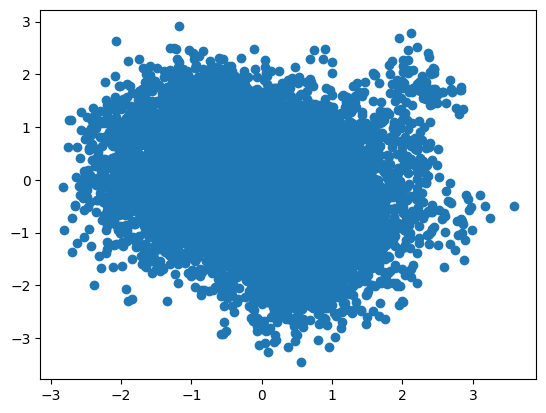

In [9]:
h = encoder.predict([x_test, y_test_cat], batch_size = 100)
plt.scatter(h[:,0], h[:,6])

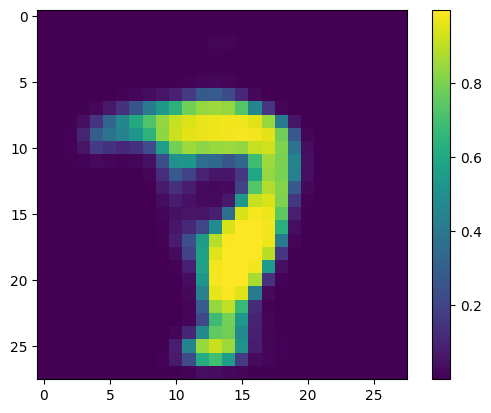

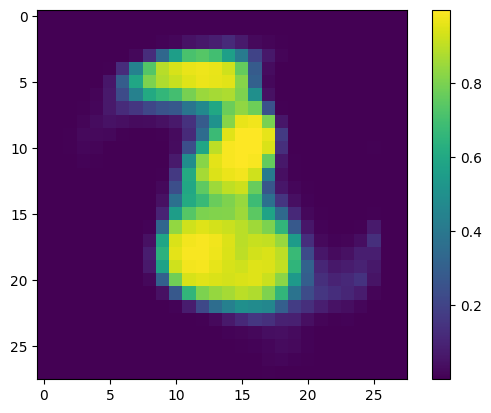

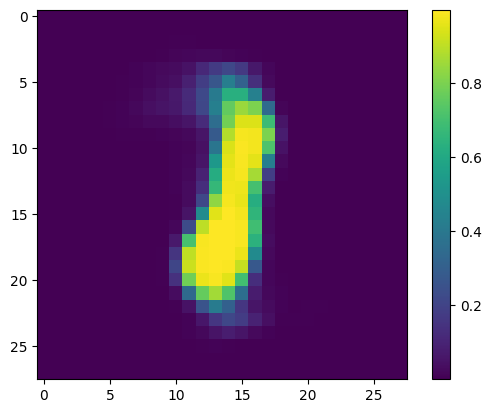

In [10]:
for i in range(3):
  plt.figure()
  plt.imshow(predictions[i].reshape(28, 28))
  plt.colorbar()
  plt.grid(False)

In [11]:
lbl = np.zeros([50, 10])

for i in range(50):
  lbl[i, i % 10] = 1


1/1 [==============================] - 0s 139ms/step


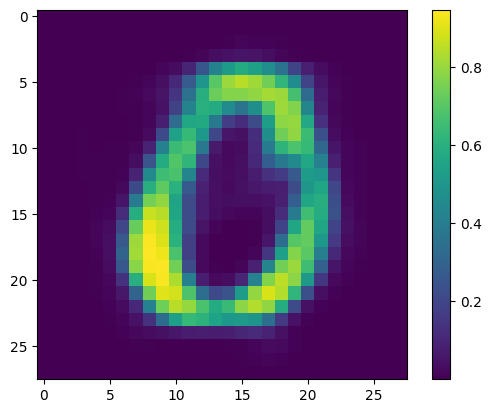

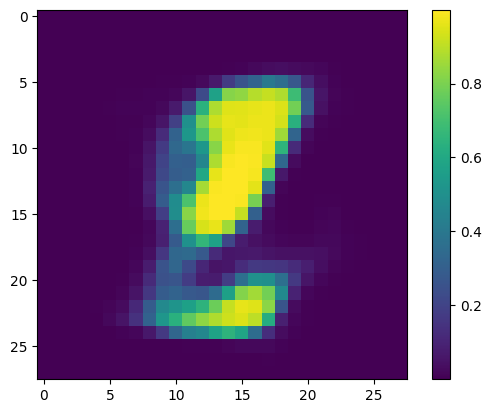

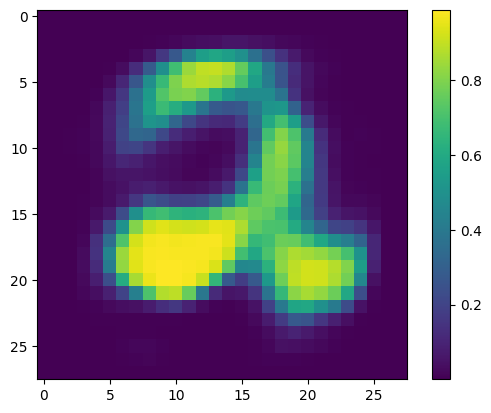

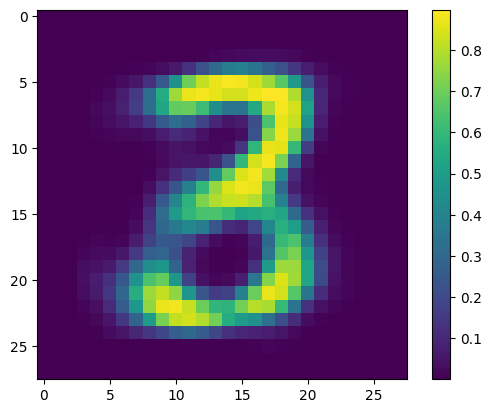

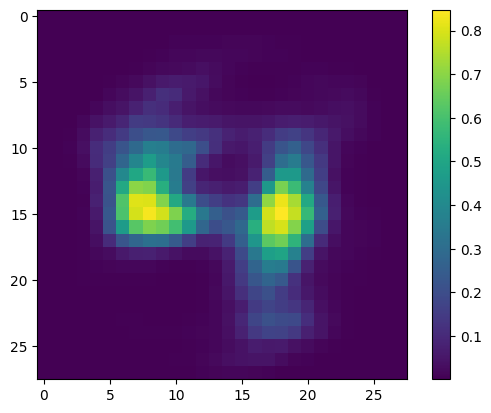

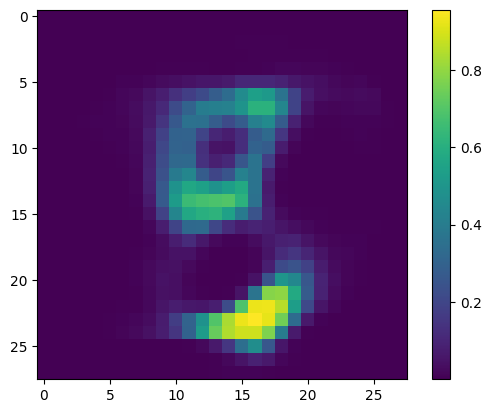

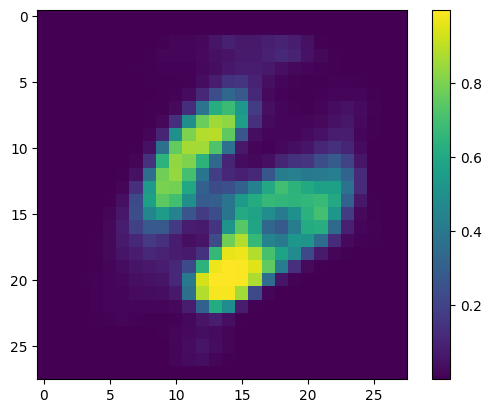

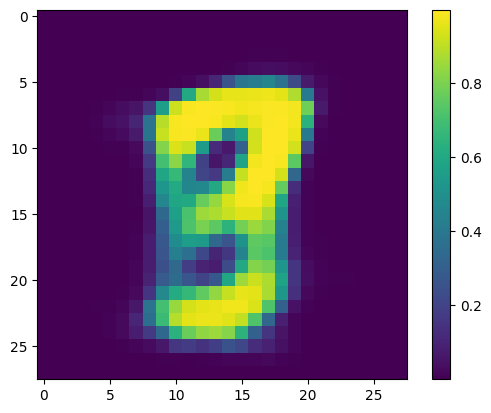

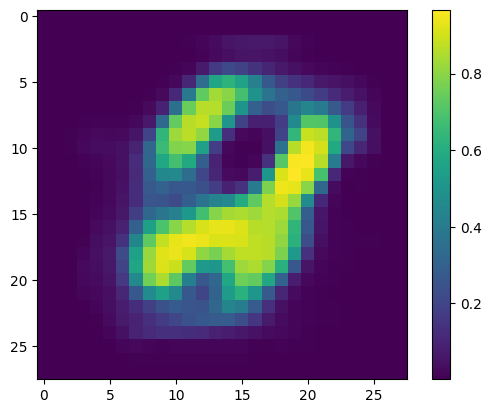

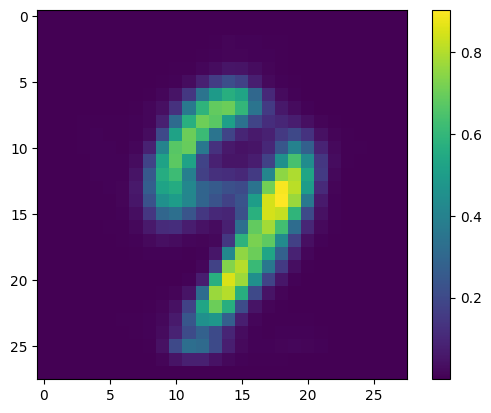

In [12]:
predictions = tr_style.predict([x_test[50:100], y_test_cat[50:100], lbl], batch_size = 50)
for i in range(10):
  plt.figure()
  plt.imshow(predictions[i + 30].reshape(28, 28))
  plt.colorbar()
  plt.grid(False)